In [1]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot

import numpy as np

import matplotlib.pyplot as plt 
from matplotlib import patches

import model.utils as utils
import model.export as export

from model.ssd_mobilenet import SSDMobileNetV2
from model.losses import SSDDetLoss
from model.anchors import SamplesEncoder, Anchors, AnchorsMobileNet
from model.export import save_model_tflite, save_model_quantized
from model.utils import show_patches, post_process_anchor
from model.quant import quantize_model, TFLiteModel, tflite_export

from spike_data import SpikeDataset

C:\ProgramData\Anaconda3\envs\sg\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Parameters

In [2]:
NUM_CLASSES = 2 
EMBEDDING_SIZE = 32
NUM_ANCHORS = 26
EPOCHS = 20
BATCH_SIZE = 16
QUANTAL_AWARE = True
INPUT_SHAPE = (128,128,3)
LOAD_MODEL = True

ANCHOR_GENERATOR = AnchorsMobileNet

INITIAL_LR = 0.01
DECAY_STEPS = 30000
LR = tf.keras.experimental.CosineDecay(INITIAL_LR, DECAY_STEPS, 1e-2)


FULL_MODEL_SAVE = "pretrained_model"
TFLITE_MODEL_SAVE = "tflite_model.tflite"
QUANTIZED_MODEL_SAVE = "quant_tflite_model.tflite"

tf.random.set_seed(0)

# Model init/compile

In [3]:
def get_model(noisy=False, fine_tune=False):
        
    model = SSDMobileNetV2(
        num_classes=NUM_CLASSES, 
        embedding_size = EMBEDDING_SIZE,
        num_anchors=4, 
        quant_aware = QUANTAL_AWARE, 
        noisy=noisy,
        input_shape=INPUT_SHAPE)
    
    
    if fine_tune:
        model.load_backbone_weights()

    loss = SSDDetLoss(num_classes=NUM_CLASSES)
    opt = tf.keras.optimizers.Adam(LR) # 0.01
        
    model.compile(opt, [loss.box_loss_, loss.embed_loss_, loss.det_loss_])
    
    return model

# Define Datasets

In [4]:
train_dataset = SpikeDataset(
    ["data\\hybrid_static_siprobe_64C_600_S11", "data\\REC_32C_600S_31"], 
    batch_size=BATCH_SIZE, 
    anchor_generator=ANCHOR_GENERATOR, 
    target_embedding=True, 
    augmentation = True
)()

if LOAD_MODEL:
    
        
    loss = EffDetLoss(num_classes=NUM_CLASSES)
    opt = tf.keras.optimizers.Adam(0.0001)
    
    
    if QUANTAL_AWARE:
        with tfmot.quantization.keras.quantize_scope():
            model = tf.keras.models.load_model("qt_model_relu.h5", #checkpoint_qt_
                                       custom_objects={
                                           "box_loss_":loss.box_loss_, 
                                           "embed_loss_":loss.embed_loss_, 
                                           "zero_loss_":loss.zero_loss_, 
                                           "det_loss_": loss.det_loss_
                                       })
    else:
        model = tf.keras.models.load_model("checkpoint.h5", 
                                           custom_objects={
                                               "box_loss_":loss.box_loss_, 
                                               "embed_loss_":loss.embed_loss_, 
                                               "zero_loss_":loss.zero_loss_, 
                                               "det_loss_": loss.det_loss_
                                           })
else:
    model = get_model()


## Visualize input data

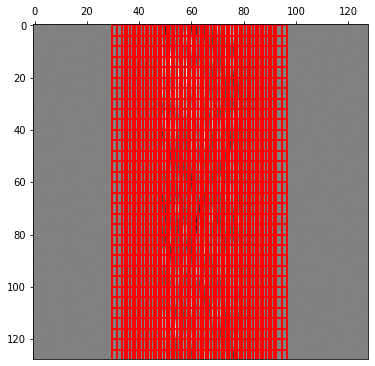

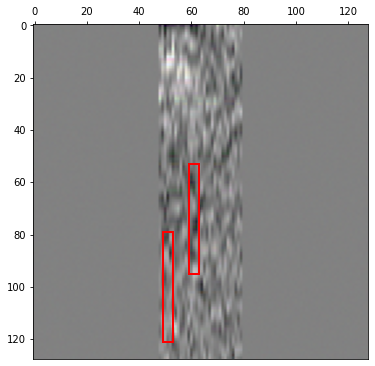

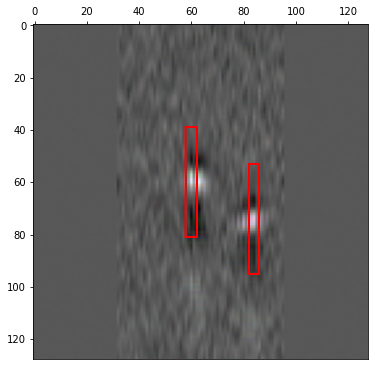

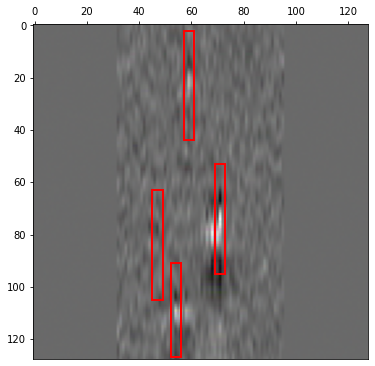

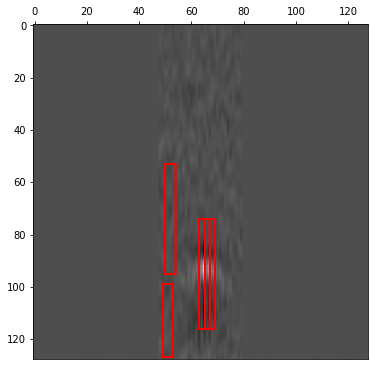

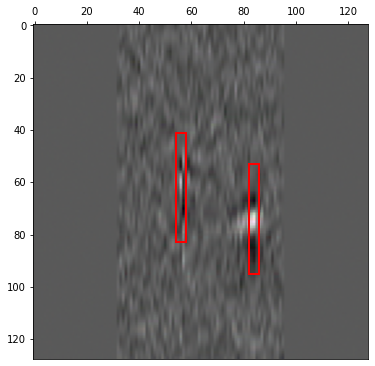

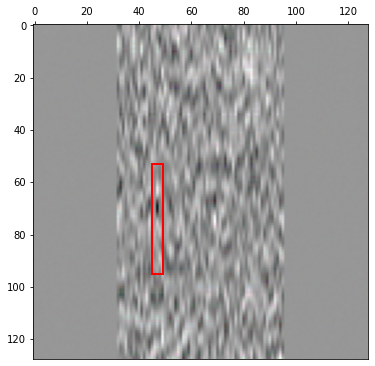

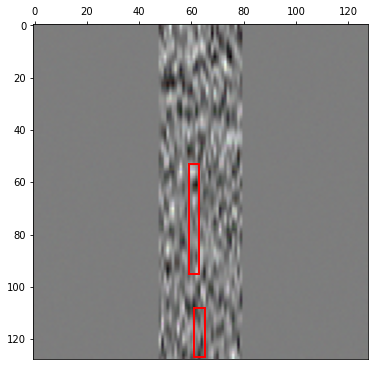

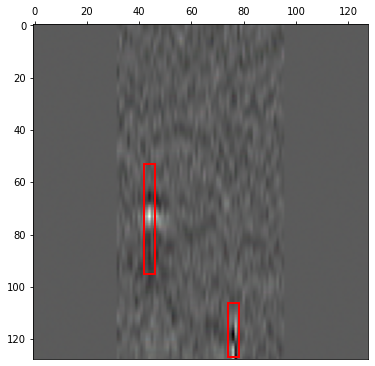

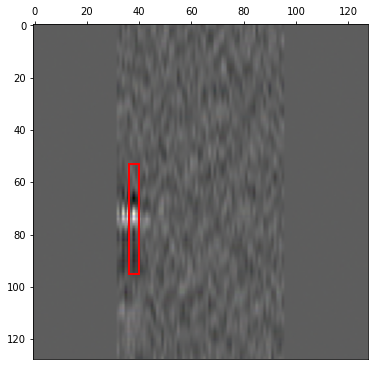

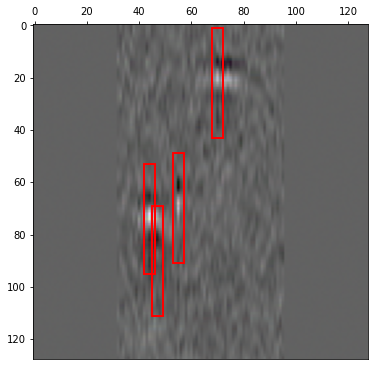

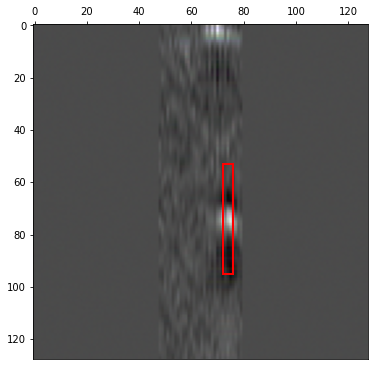

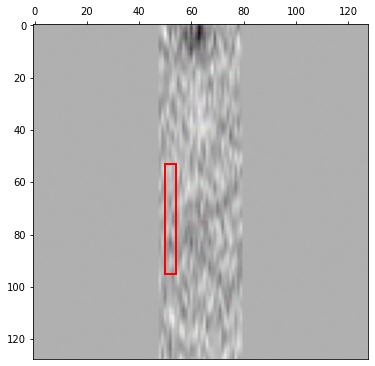

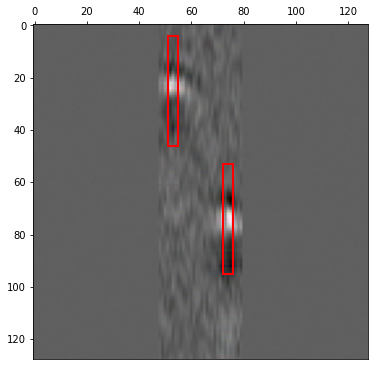

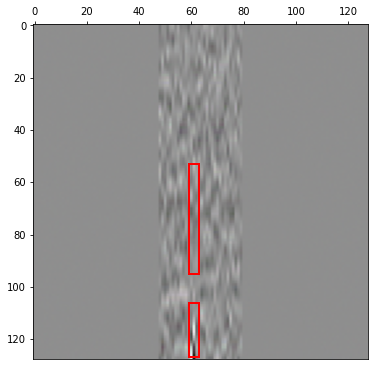

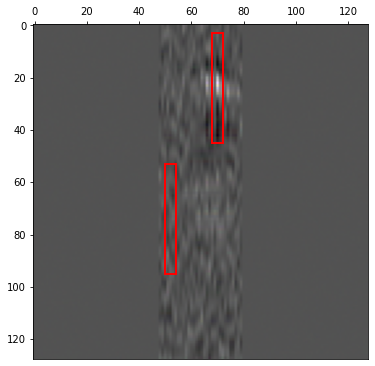

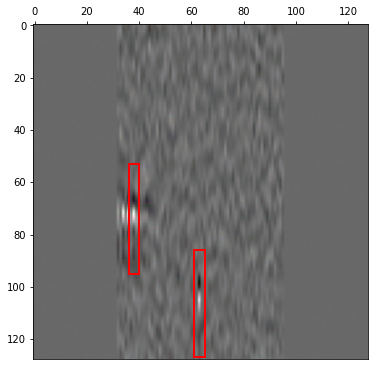

In [6]:
#"""
from model.utils import to_corners

s_a = ANCHOR_GENERATOR()
anchors = s_a.get_anchors()
sample = next(iter(train_dataset))


show_patches(sample[0][0], to_corners(anchors* [[128,128,128,128]]))


boxes, scores, labels = post_process_anchor(sample[1], anchor_generator=ANCHOR_GENERATOR)

show_patches(sample[0], boxes)
#"""

# Training

In [11]:
model.fit(train_dataset, epochs=EPOCHS, callbacks=[], use_multiprocessing=True)

Epoch 1/30
  13717/Unknown - 1480s 108ms/step - loss: -0.8510 - reshape_loss: 0.1756 - reshape_3_loss: -1.1193 - softmax_loss: 0.0927

KeyboardInterrupt: 

In [14]:
model.save("checkpoint.h5")

### Evaluate model prediction visually 

In [12]:
val_dataset = SpikeDataset(
    ["data\\1103_1_1"], 
    batch_size=128, 
    anchor_generator=ANCHOR_GENERATOR, 
    target_embedding=True,
    use_cache=False
)()

sample = next(iter(val_dataset))

out = model(sample[0])

0.5 threshold: (2088,)
0.3 threshold: (4591,)
0.1 threshold: (7075,)
Negative:
 [[0.7293367  0.72950053 0.72926027 ... 0.7297821  0.7296732  0.7292612 ]
 [0.72957593 0.72976285 0.72964156 ... 0.72963536 0.7293514  0.7289066 ]
 [0.72937036 0.7296178  0.72942823 ... 0.72989583 0.7295771  0.7294152 ]
 ...
 [0.7294085  0.7296671  0.7293922  ... 0.7299141  0.72963464 0.72951204]
 [0.7293154  0.72953445 0.7292827  ... 0.72985697 0.7296438  0.72938776]
 [0.7293725  0.7295889  0.72933185 ... 0.72982687 0.7294117  0.72918075]]
Detected: 
 [[0.50218505 0.50197756 0.5022817  ... 0.5016207  0.50175864 0.5022806 ]
 [0.5018819  0.5016451  0.5017988  ... 0.5018067  0.5021664  0.5027295 ]
 [0.5021424  0.50182897 0.5020691  ... 0.50147647 0.5018804  0.5020856 ]
 ...
 [0.50209403 0.5017663  0.5021148  ... 0.50145334 0.5018076  0.50196296]
 [0.502212   0.5019345  0.5022535  ... 0.5015258  0.5017959  0.50212026]
 [0.5021396  0.5018655  0.5021912  ... 0.50156397 0.50209004 0.5023824 ]]
tf.Tensor([ 1. -1. -

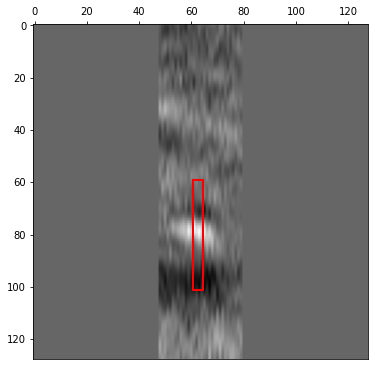

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


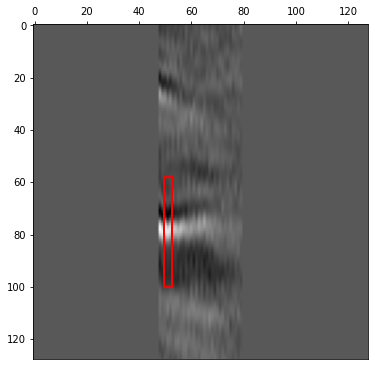

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


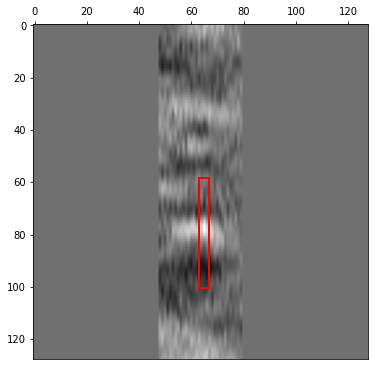

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


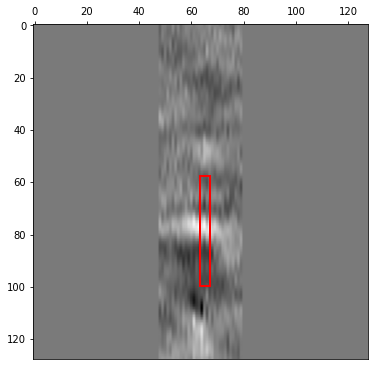

tf.Tensor([ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


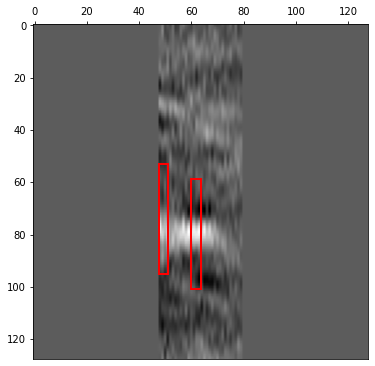

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


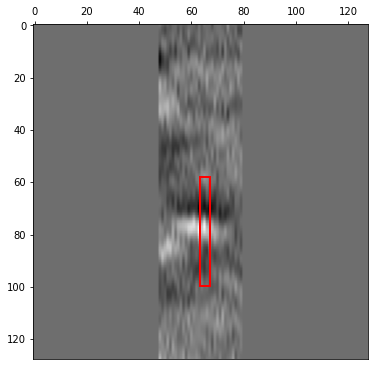

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


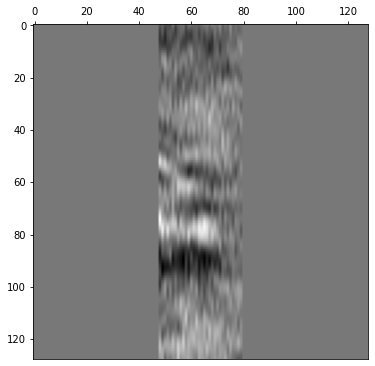

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


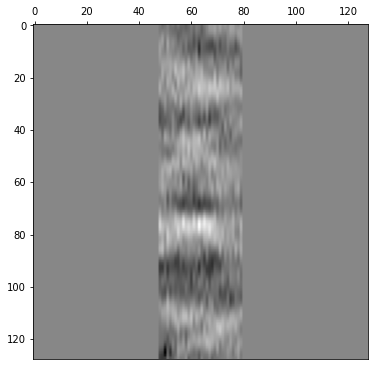

tf.Tensor([ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


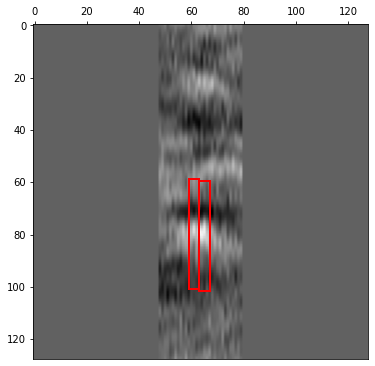

tf.Tensor([-1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


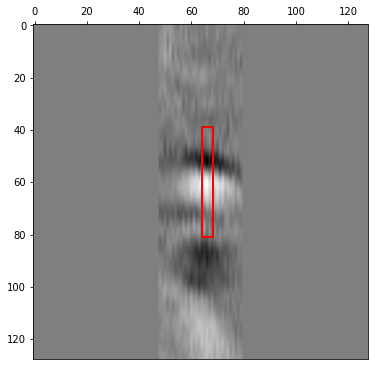

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


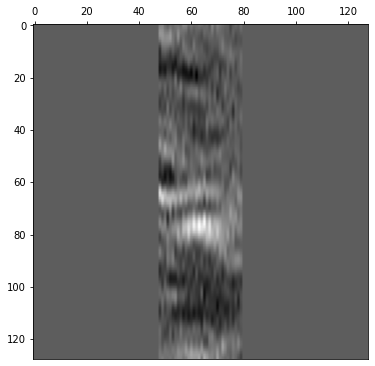

tf.Tensor([-1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


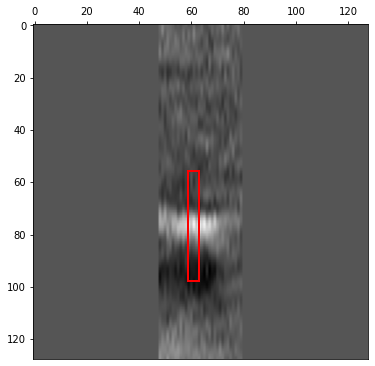

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


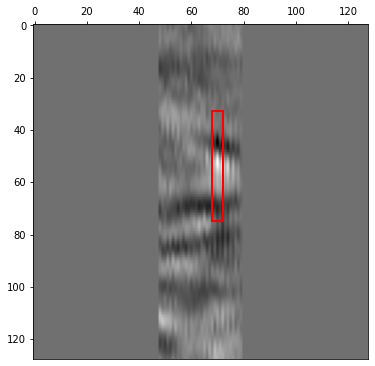

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


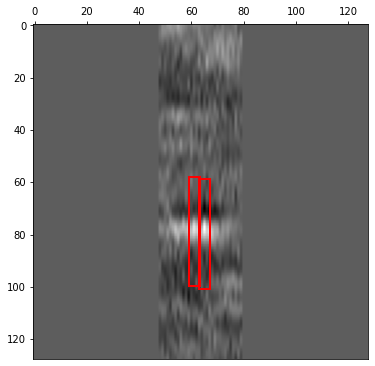

tf.Tensor([-1.  1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


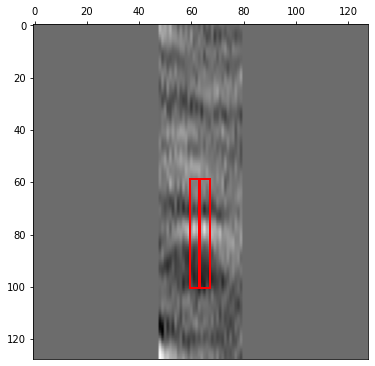

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


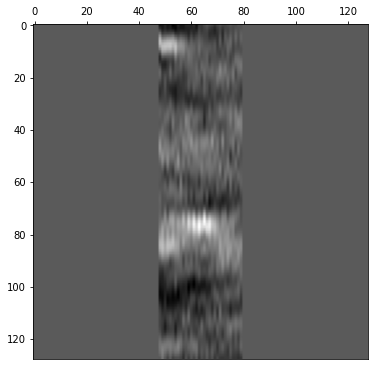

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


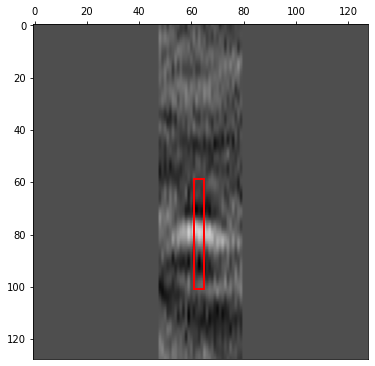

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


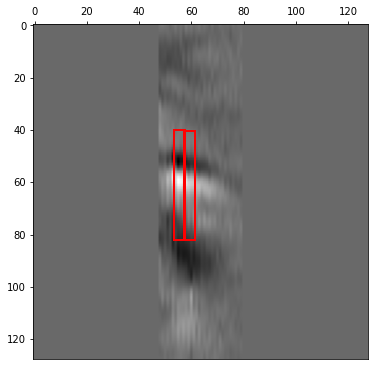

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


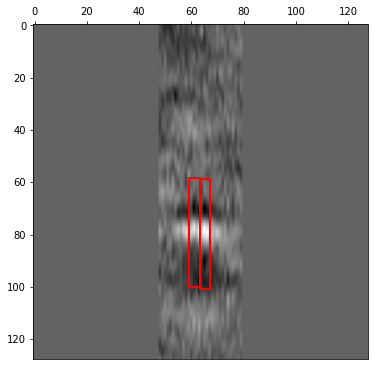

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


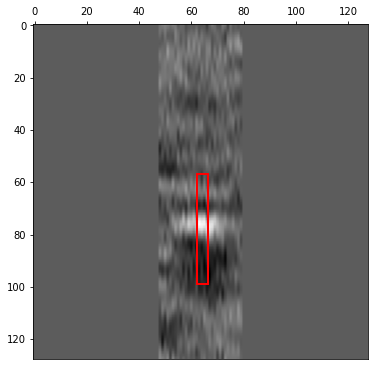

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


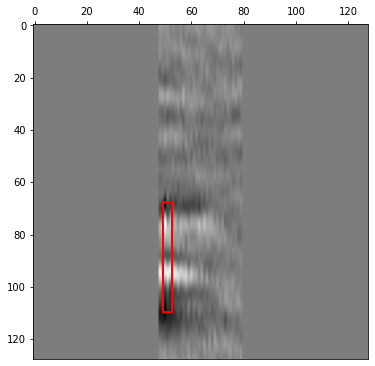

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


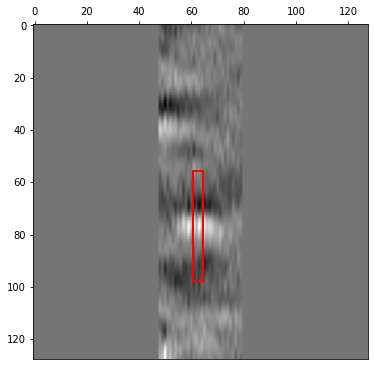

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


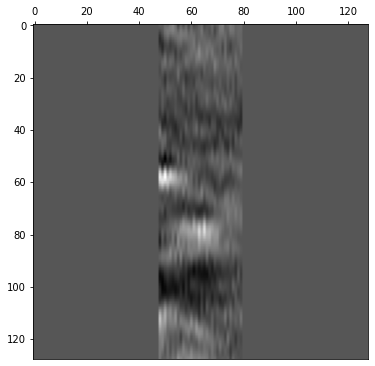

tf.Tensor([-1. -1. -1. -1. -1.  1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


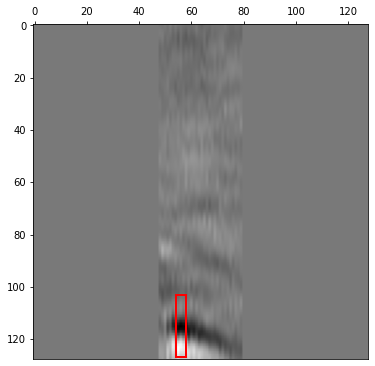

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


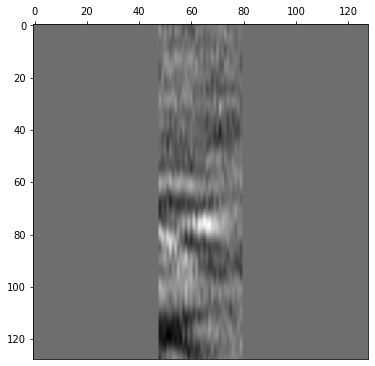

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


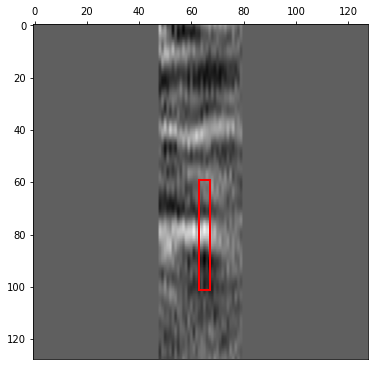

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


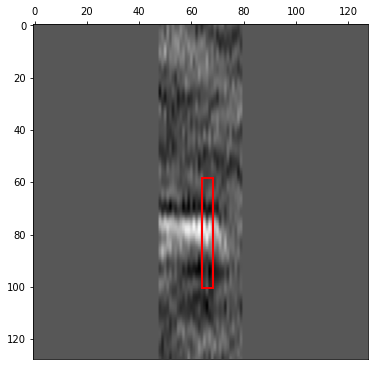

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


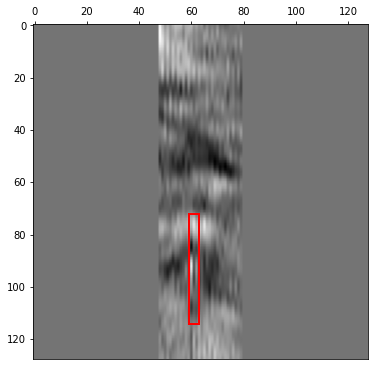

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


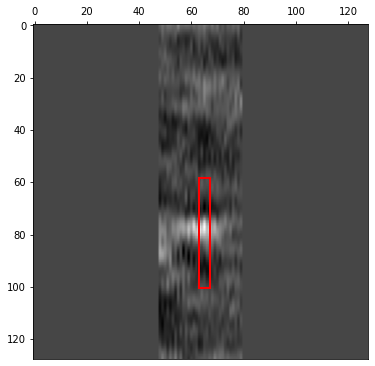

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


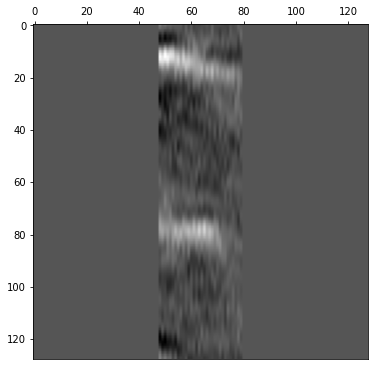

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


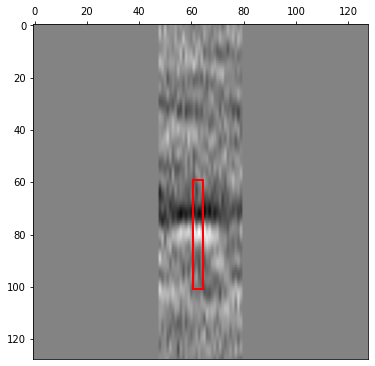

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


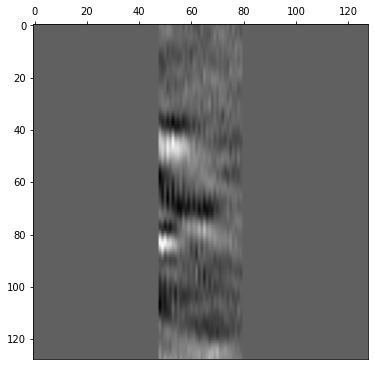

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


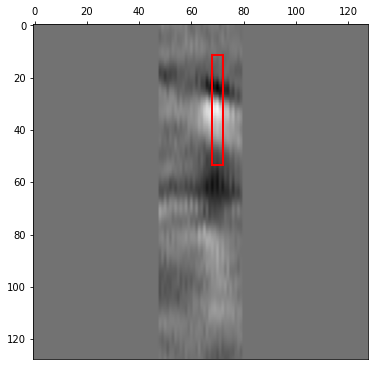

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


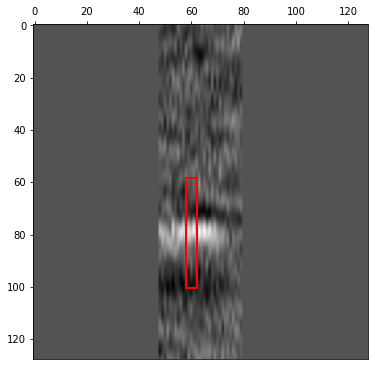

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


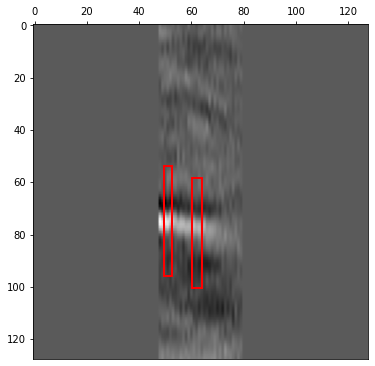

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


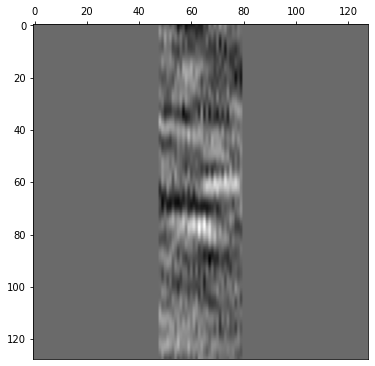

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


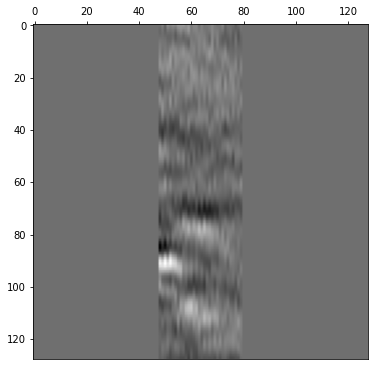

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


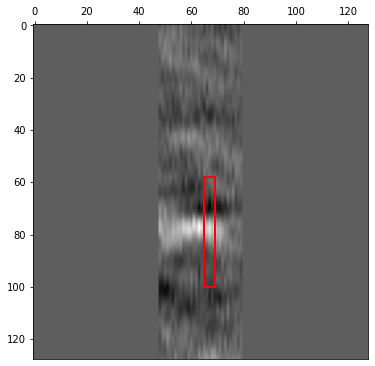

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


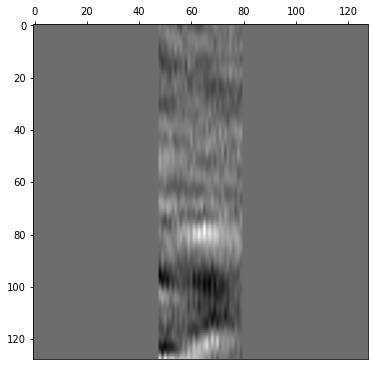

tf.Tensor([-1. -1. -1. -1. -1.  1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


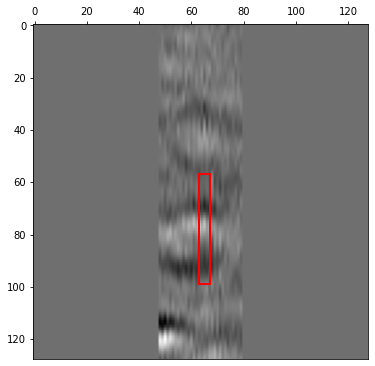

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


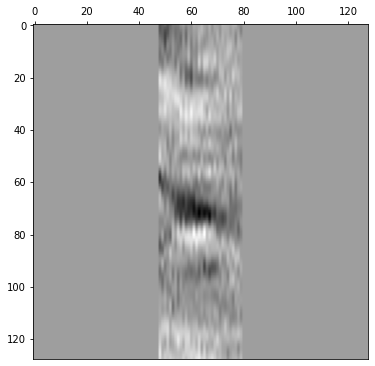

tf.Tensor([-1. -1. -1. -1.  1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


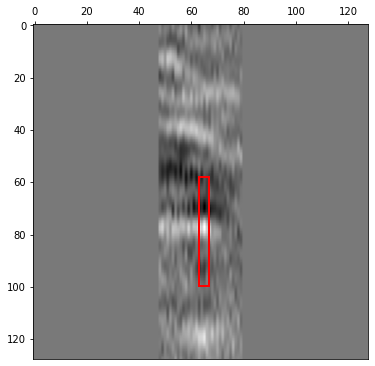

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


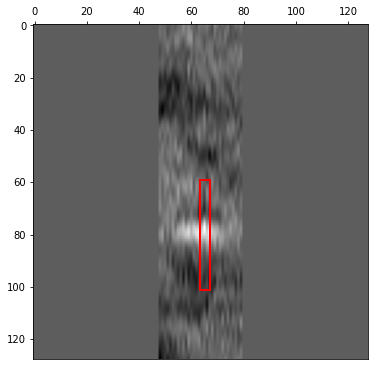

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


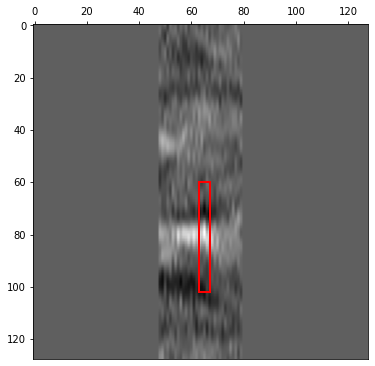

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


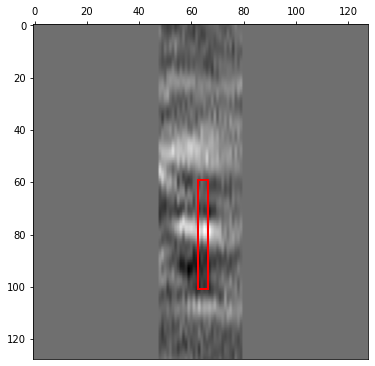

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


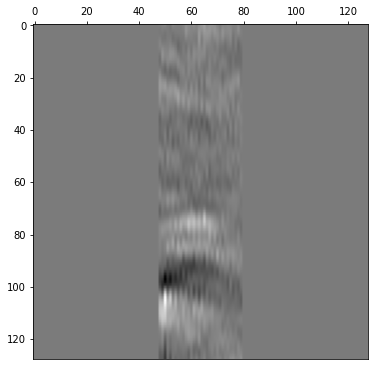

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


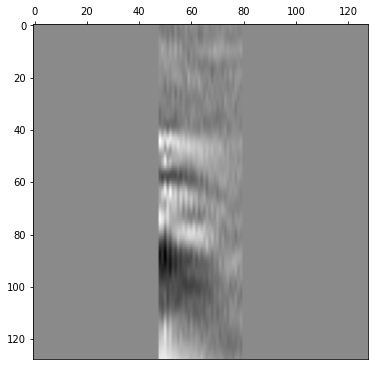

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


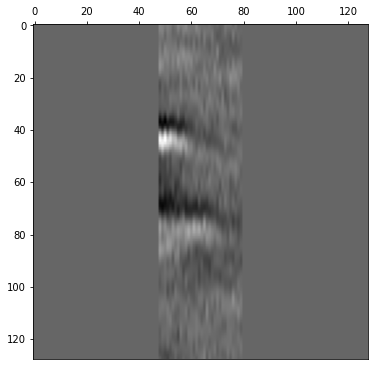

tf.Tensor([ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


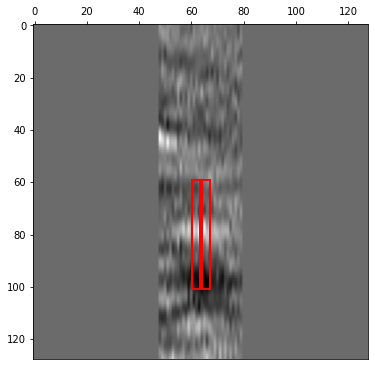

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


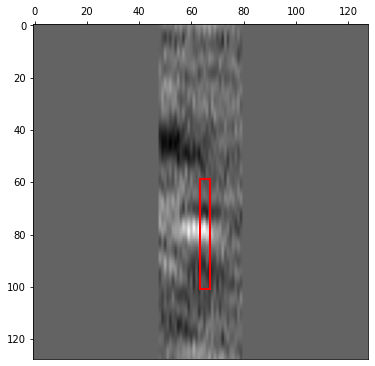

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


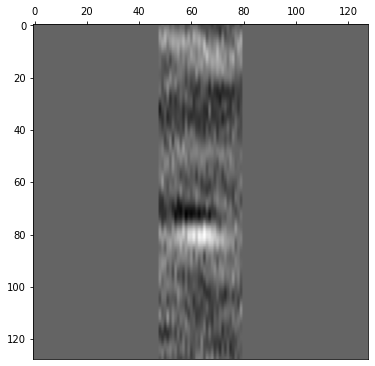

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


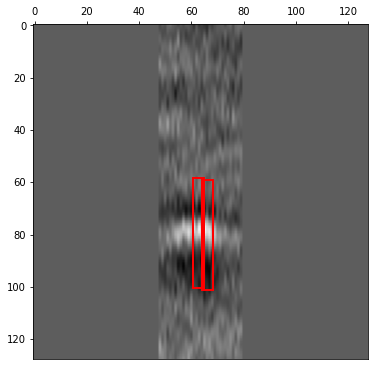

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


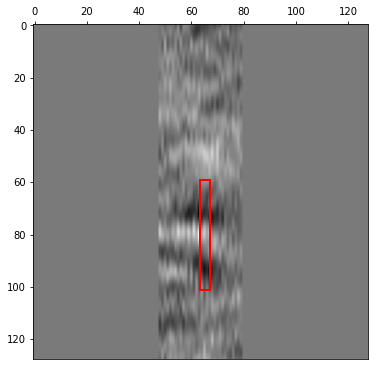

tf.Tensor([ 1. -1. -1. -1.  1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


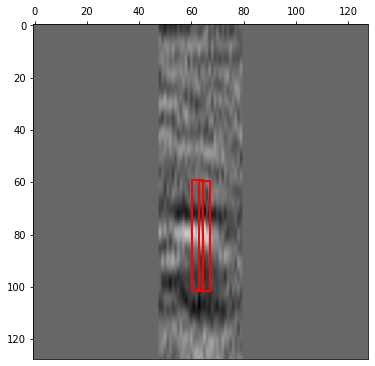

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


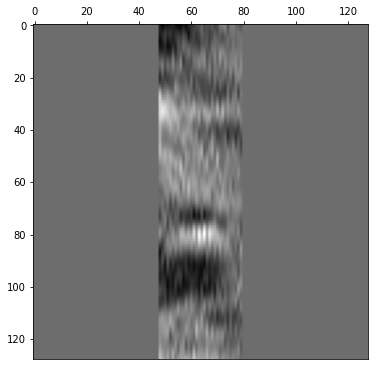

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


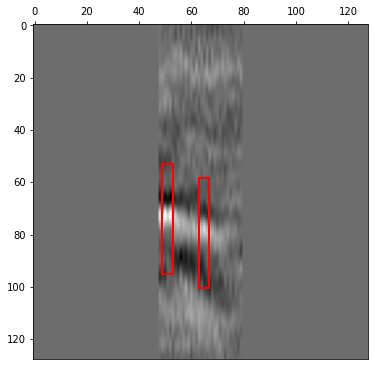

tf.Tensor([-1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


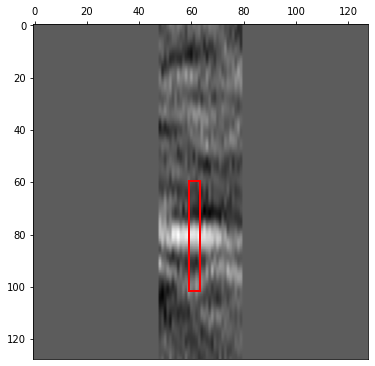

tf.Tensor([-1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


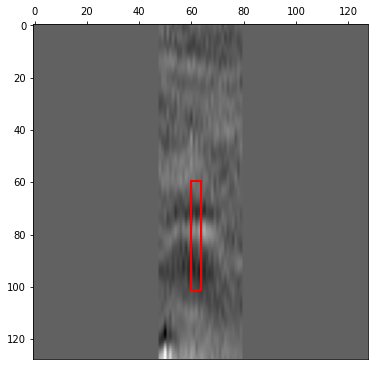

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


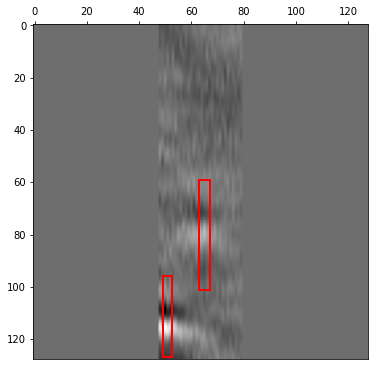

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


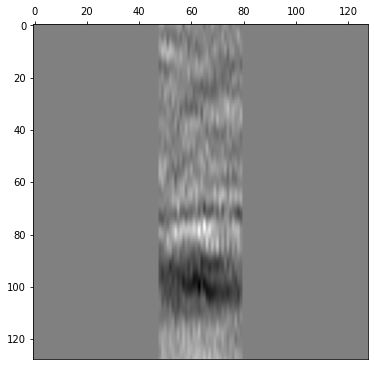

tf.Tensor([-1. -1. -1. -1. -1.  1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


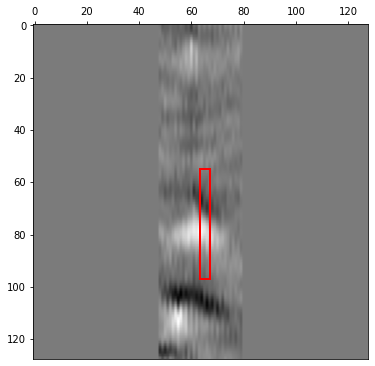

tf.Tensor([ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


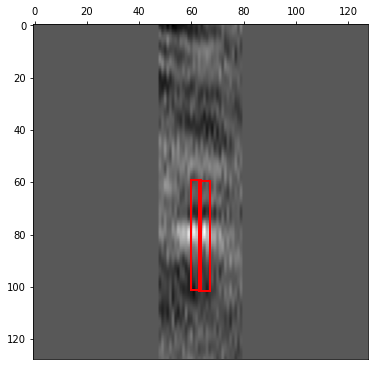

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


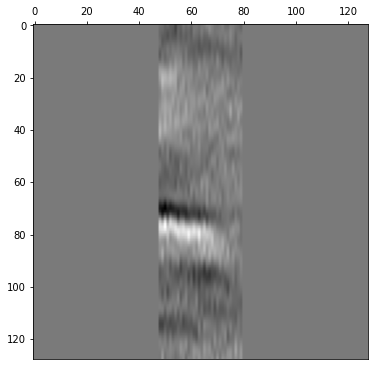

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


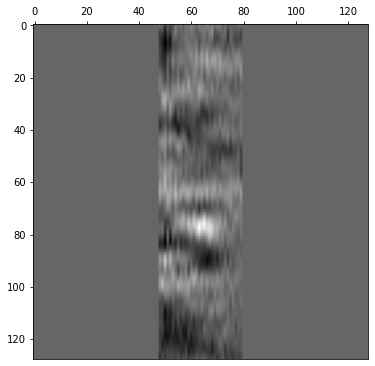

tf.Tensor([-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


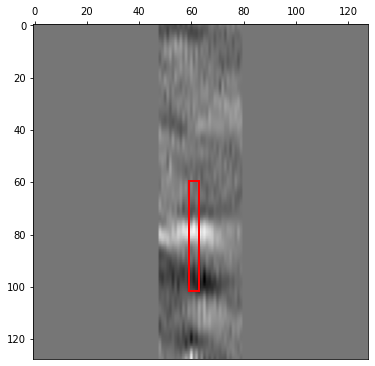

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


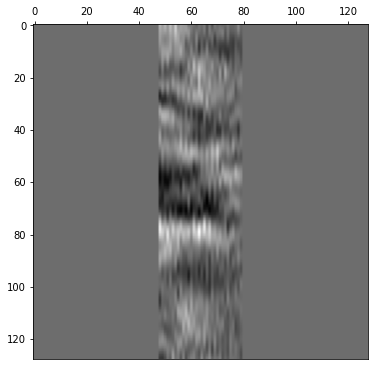

tf.Tensor([-1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


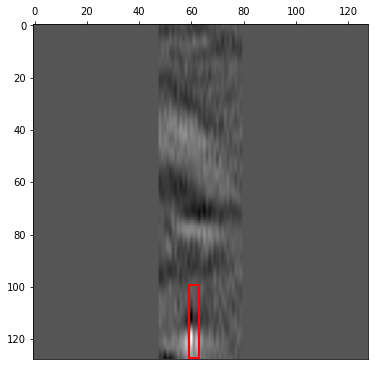

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


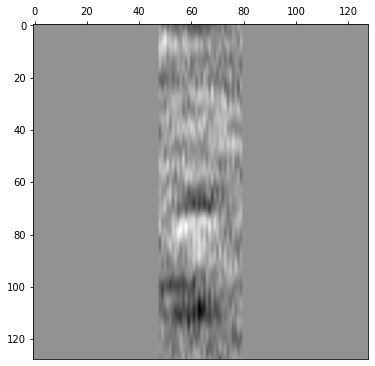

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


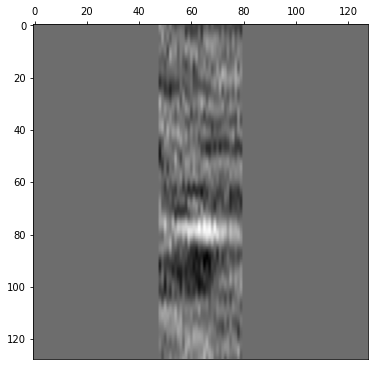

tf.Tensor([ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


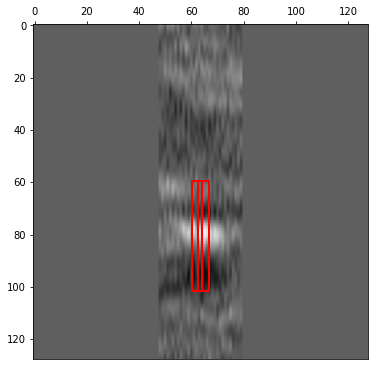

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


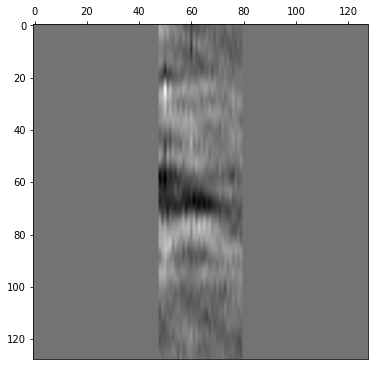

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


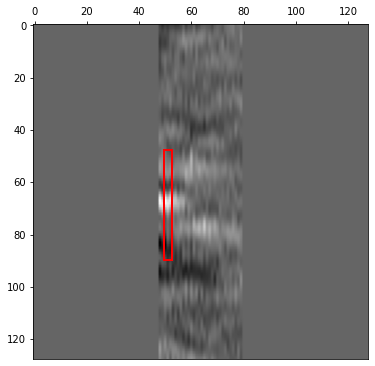

tf.Tensor([ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


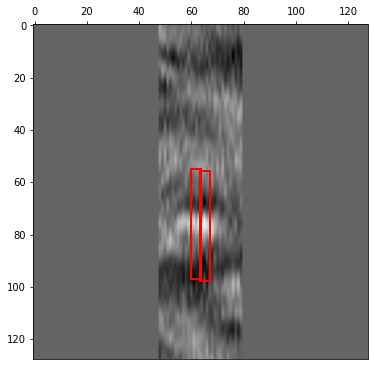

tf.Tensor([-1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


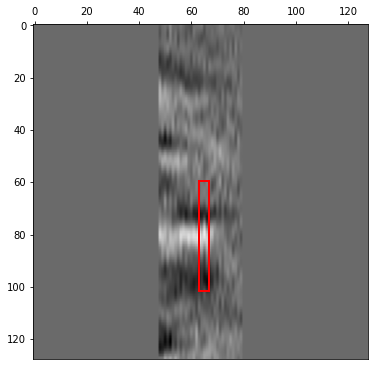

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


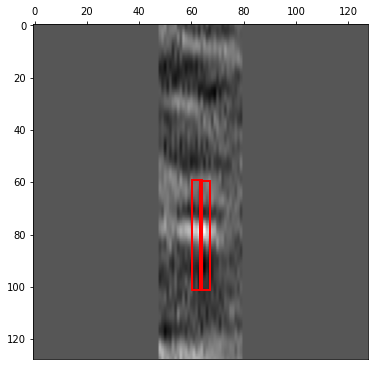

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


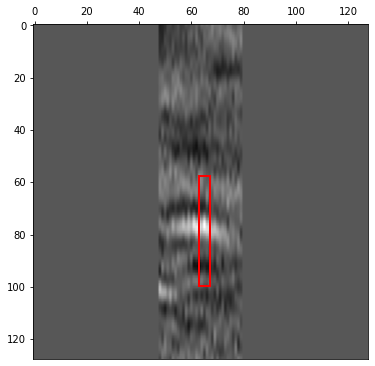

tf.Tensor([ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


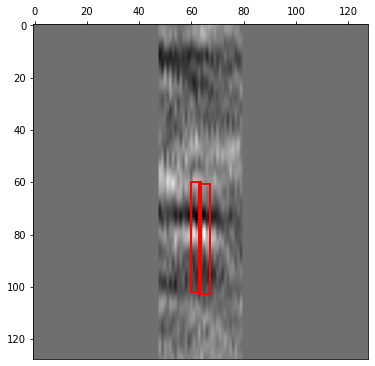

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


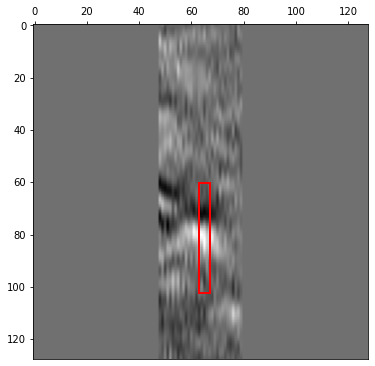

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


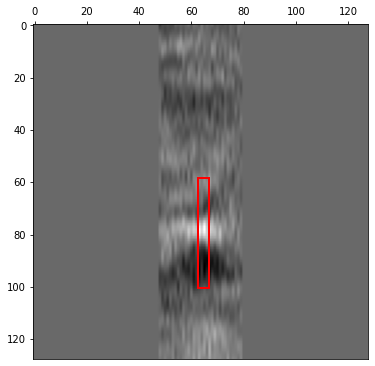

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


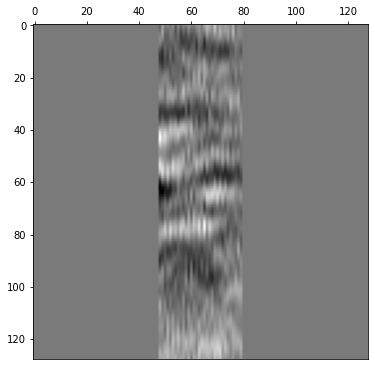

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


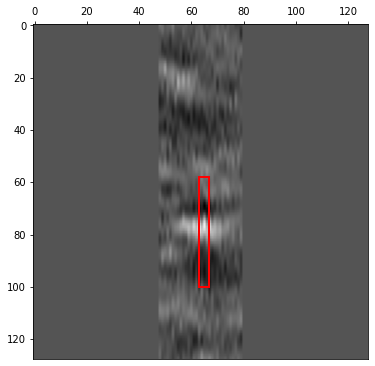

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


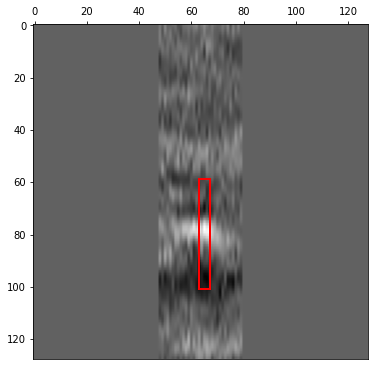

tf.Tensor([ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


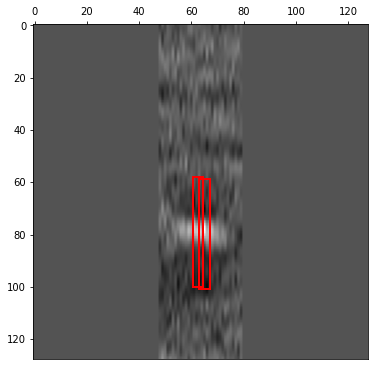

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


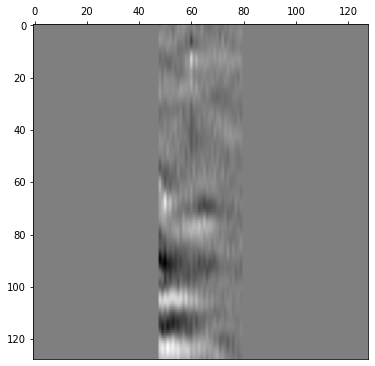

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


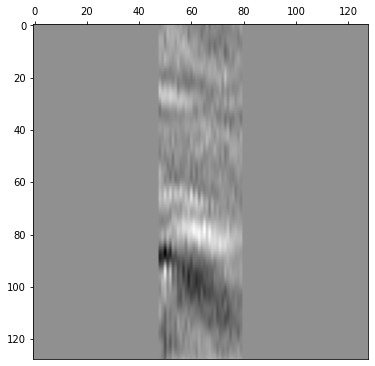

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


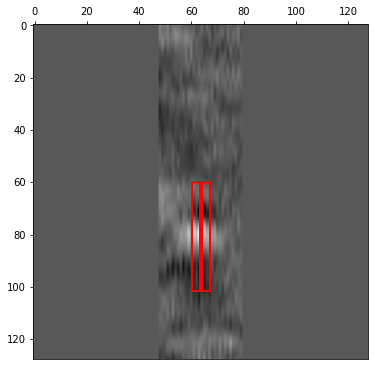

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


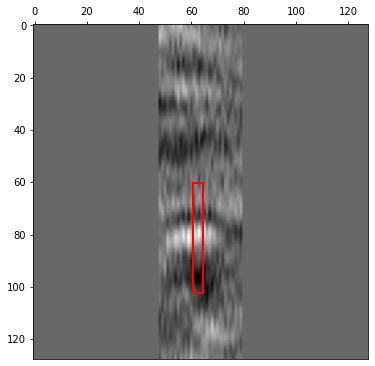

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


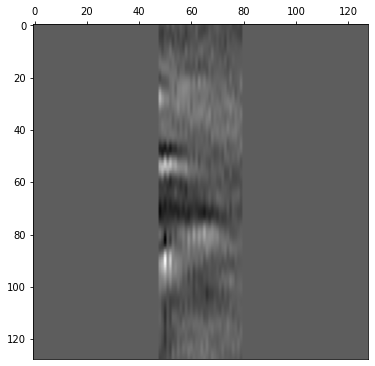

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


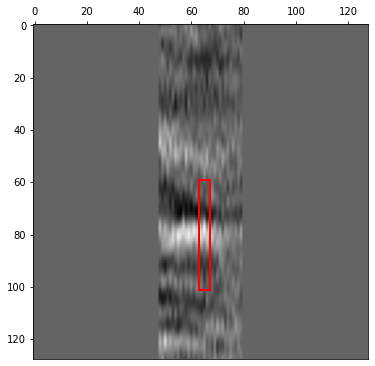

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


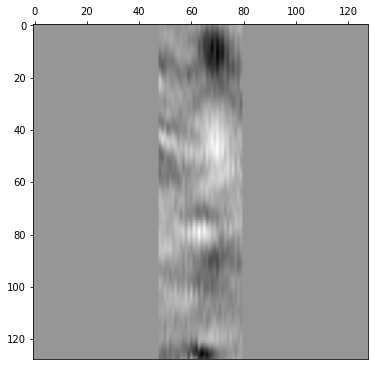

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


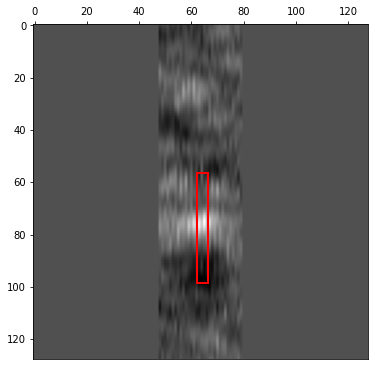

tf.Tensor([ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


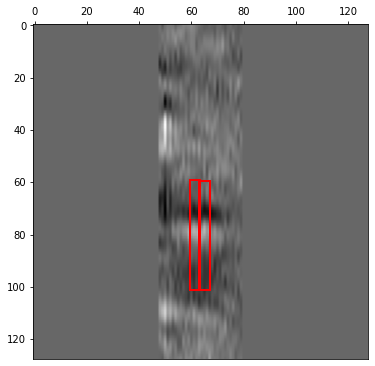

tf.Tensor([-1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


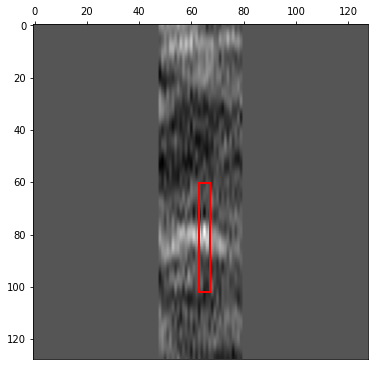

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


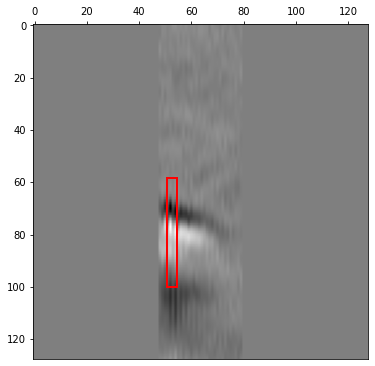

tf.Tensor([ 1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


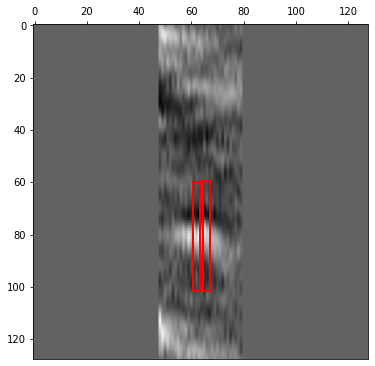

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


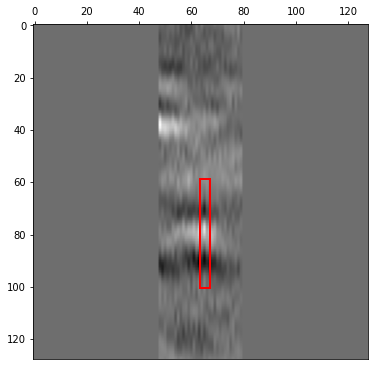

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


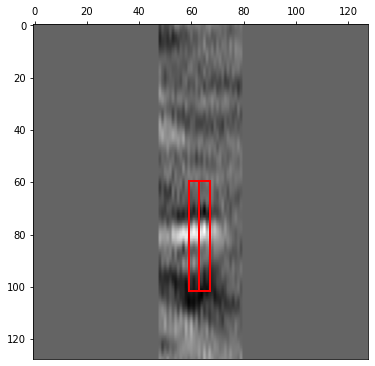

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


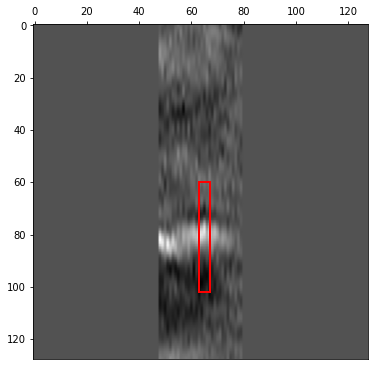

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


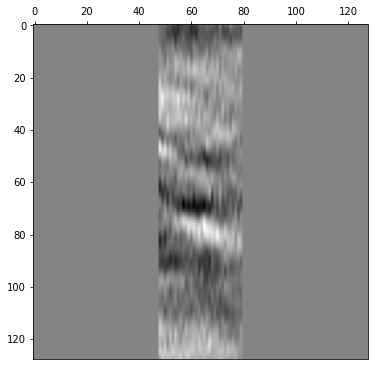

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


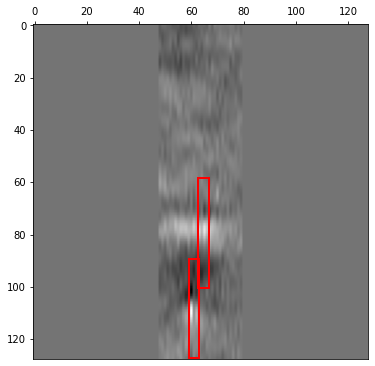

tf.Tensor([-1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


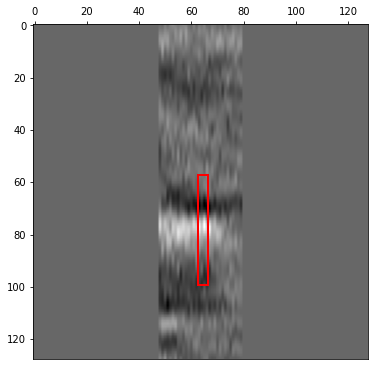

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


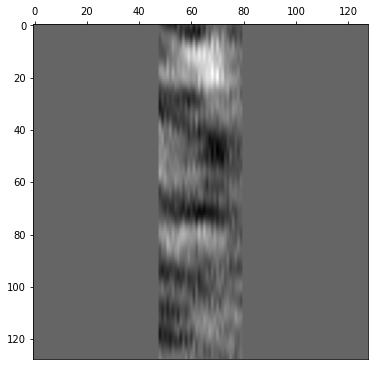

tf.Tensor([ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


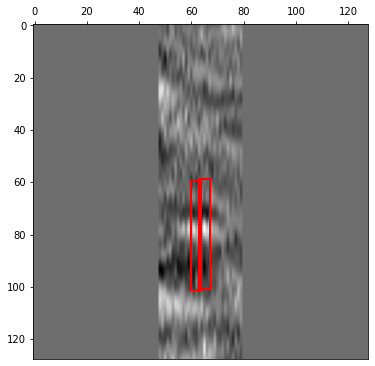

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


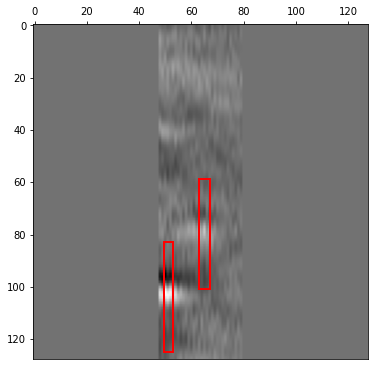

tf.Tensor([ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


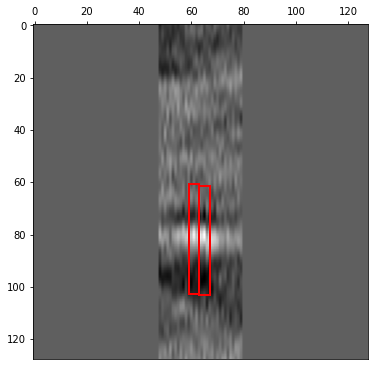

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


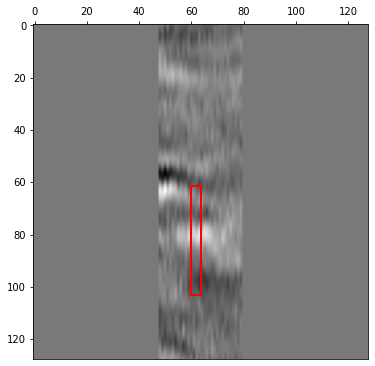

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1.  1. -1.], shape=(10,), dtype=float32)


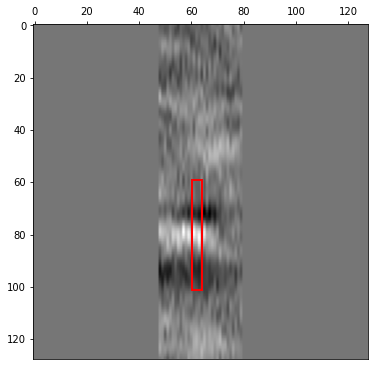

tf.Tensor([ 1. -1. -1. -1. -1. -1.  1. -1. -1. -1.], shape=(10,), dtype=float32)


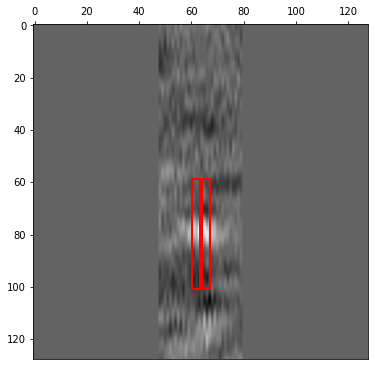

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


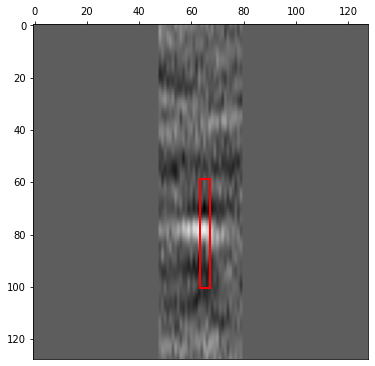

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


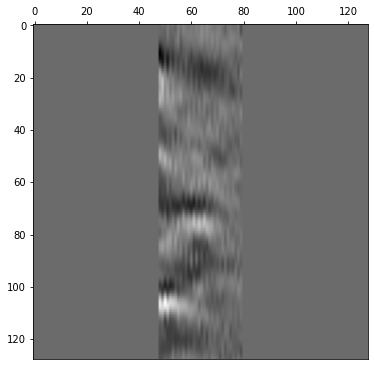

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


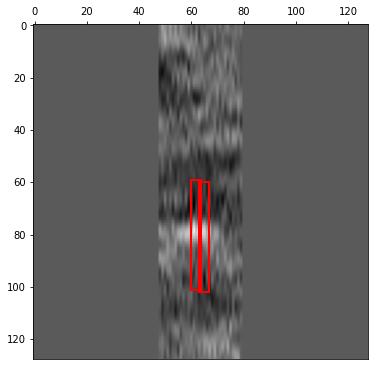

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


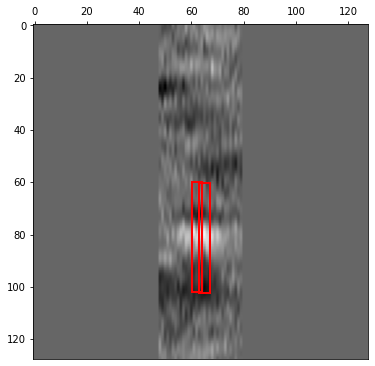

tf.Tensor([ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


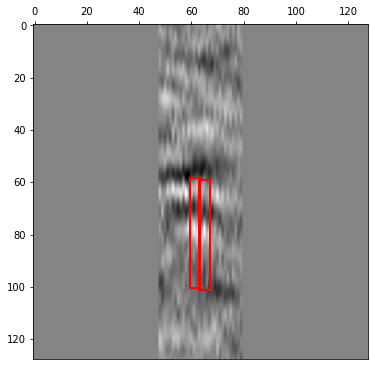

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


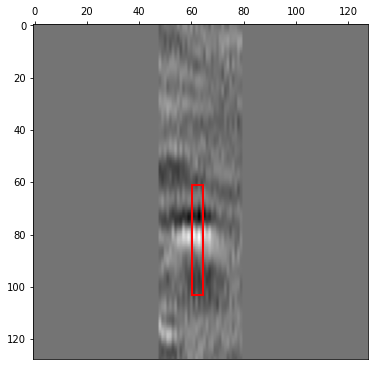

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


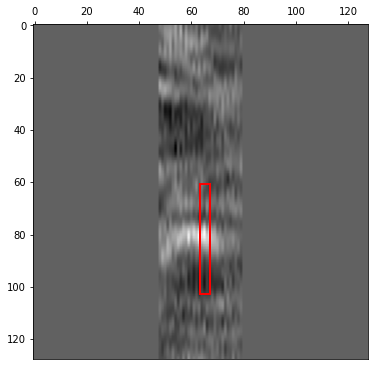

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1.  1. -1.], shape=(10,), dtype=float32)


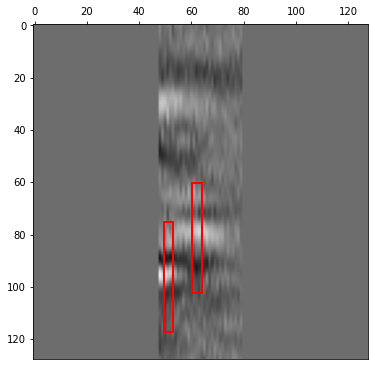

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


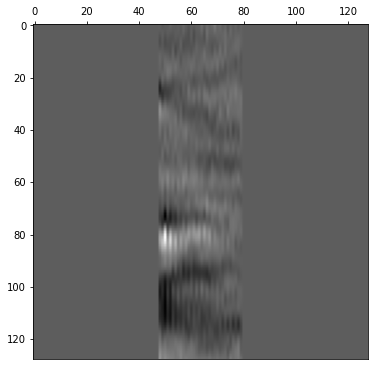

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


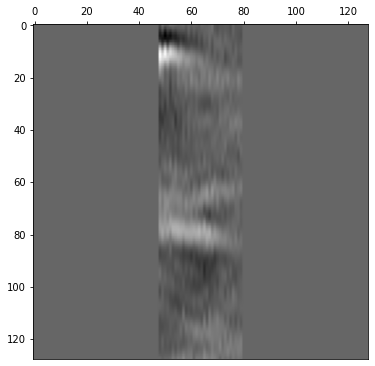

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


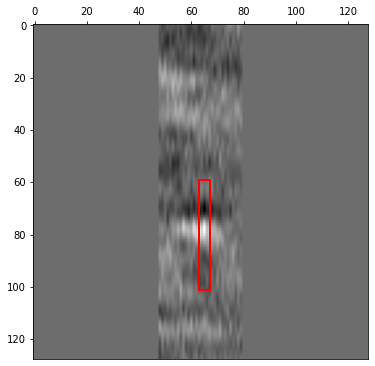

tf.Tensor([-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


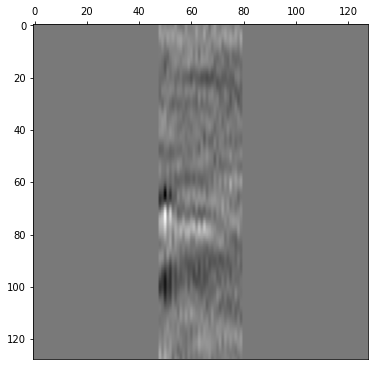

tf.Tensor([ 1. -1. -1.  1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


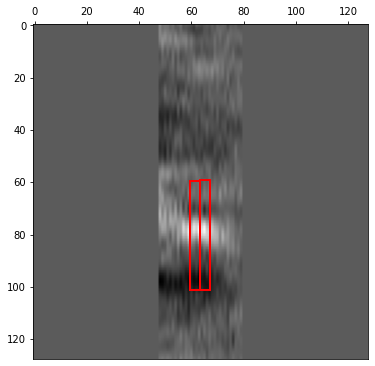

tf.Tensor([-1. -1.  1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


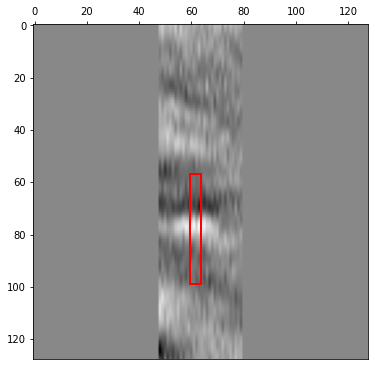

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


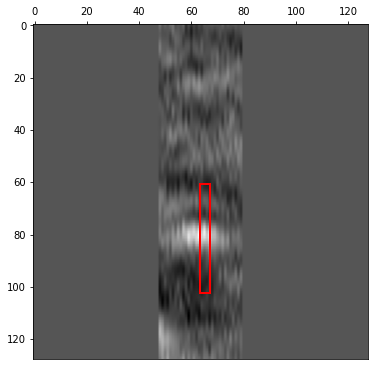

tf.Tensor([-1. -1. -1. -1.  1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


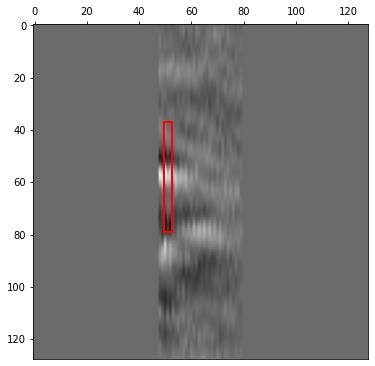

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1.  1. -1. -1.], shape=(10,), dtype=float32)


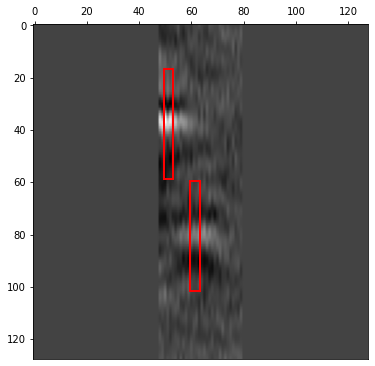

tf.Tensor([ 1. -1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


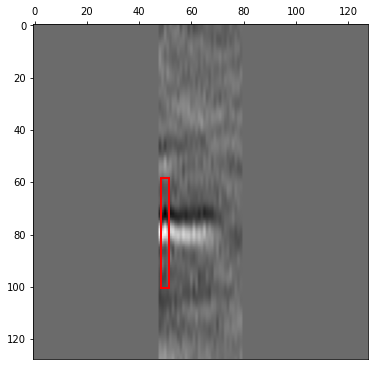

tf.Tensor([ 1.  1. -1. -1. -1. -1. -1. -1. -1. -1.], shape=(10,), dtype=float32)


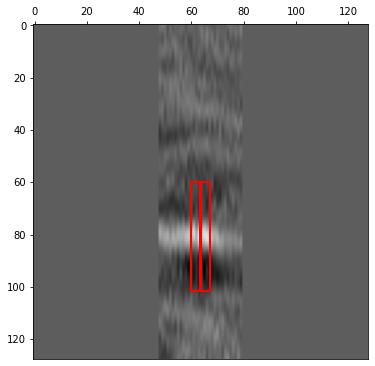

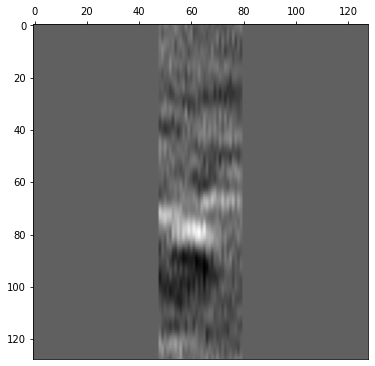

In [13]:
from model.utils import show_patches, post_process_anchor
%matplotlib inline

k = out[2][:,:,1]

b, s, l = post_process_anchor(out, threshold=0.2,num_classes=2, score_threshold=0.9, class_specific_filter=False, anchor_generator=ANCHOR_GENERATOR)
show_patches(sample[0], b, labels=l)


In [ ]:
%matplotlib inline
print("Ground truth : ")
boxes, scores, labels = post_process_anchor(sample[1], anchor_generator=ANCHOR_GENERATOR)
show_patches(sample[0], boxes, labels=labels)
print("In time domain: ")
plt.plot(sample[0][0,:,:,0])
plt.show()
#"""

In [ ]:

from importlib import reload

reload(export)

from model.export import custom_postprocess

it = iter(train_dataset)

ypred_cluster_feature = []
ytrue_cluster_idx =  []
channel_num = []

for i in range(500):
    
    print(i, end="\r")
    sample = next(it)
    
    out = model(sample[0])
    
    fff = tf.squeeze(tf.greater(sample[1][2][0], 0))
    fff2 = tf.squeeze(tf.greater(out[2][0][...,1], 0.9))
    
    embedding_gt = tf.boolean_mask(out[1][0], fff)
    true = tf.boolean_mask(sample[1][2][0], fff)[...,0]

    embedding_gt = embedding_gt[...,1:]
    
    true= tf.math.round(true)
    
    ypred_cluster_feature.extend(embedding_gt)
    ytrue_cluster_idx.extend(true)
    
ypred_cluster_feature = np.array(ypred_cluster_feature)
ytrue_cluster_idx = np.array(ytrue_cluster_idx)


ytrue_cluster_idx = np.squeeze(ytrue_cluster_idx)
ypred_cluster_feature = np.array(ypred_cluster_feature)

In [ ]:
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=1000000)

%matplotlib qt 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np

pca = PCA(n_components=2)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', verbose=True, perplexity=30)

result = pca.fit_transform(ypred_cluster_feature)
result = tsne.fit_transform(ypred_cluster_feature)


def res(x, label):
    
    uni = np.unique(label)
    for u in uni:
        
        lu = label[label==u]
        xu = x[label==u]
        
        rgb = np.random.rand(3,)
        plt.scatter(xu[:,0], xu[:,1], color=[rgb])
        
        plt.show()
    
res(result, ytrue_cluster_idx)

In [ ]:
%matplotlib qt
from sklearn.cluster import KMeans
from scipy.special import comb
import sklearn

ex = result
labels = ytrue_cluster_idx


no_unique_clusters = np.unique(labels).shape[0]
print(f"Unique clusters : {no_unique_clusters}")


best_clust_num = 0
best_score = 0

for i in range(1, no_unique_clusters+1):
    
    print(f"Currently trying with cluster_no = {i} ", end="\r")
    
    kmeans = KMeans(
        init="random",
        n_clusters=i,
        n_init=20,
        max_iter=500,
        random_state=42
    )

    kmeans.fit(ypred_cluster_feature)

    k_labels = list(kmeans.labels_)
    
    score = sklearn.metrics.adjusted_rand_score(labels, k_labels)
    
    if score > best_score:
        best_score = score
        best_clust_num = i

print()
print(f"Best Adjusted_rand_score is {best_score} with {best_clust_num} clusters")


In [ ]:
%matplotlib inline

from sklearn.neighbors import DistanceMetric
import scipy
import sklearn
dist = DistanceMetric.get_metric('euclidean')  # euclidean or manhattan

clusters = [] 
cluster_means = []
cluster_positions = []

main_labels = ytrue_cluster_idx
main_res = ypred_cluster_feature

for l in np.unique(main_labels):
    
    means = np.mean(main_res[main_labels == l], axis=0)
    pos = np.mean(channel_num[main_labels == l])
    cluster_means.append(means)
    cluster_positions.append(pos)
    
cluster_means = np.array(cluster_means)
cluster_positions = np.array(cluster_positions)


## Similarity #################

#"""
#sim = tf.matmul(cluster_means, cluster_means, transpose_b=True)

sim = dist.pairwise(cluster_means)
sim = sim - np.min(sim, axis=0)
sim = sim / np.max(sim, axis=0)

sim = 1 - sim

#"""



## Position ####################
cluster_positions = np.expand_dims(cluster_positions, 1)
pos = scipy.spatial.distance_matrix(cluster_positions, cluster_positions)
pos = pos - np.min(pos)
pos = pos / 64#np.max(pos)
pos = 1 - pos
pos = pos #**3

## Combination #################
comb = sim * pos
comb = comb / np.max(comb)


plt.matshow(sim)
plt.title("Similarity/Distance matrix - Sim")

plt.matshow(pos)
plt.title("Channel 1-(distance normalized) - CH")

plt.matshow(comb)
plt.title("Sim matrix combined with distance - Sim * CH")

max_val = np.max(comb - np.diag(np.diag(comb)))
print(f"Max value (excluding diagonals): {max_val}")


comb = np.where(comb < .8, 0, comb)
plt.matshow(comb)
plt.title("Sim matrix combined with distance - .8 thresholded")

remaining_candidates = (np.count_nonzero(comb) - comb.shape[0]) / 2 

print(f"Remaining candidates: {remaining_candidates}")

In [ ]:
sample = next(iter(val_dataset))
out = model.predict(sample[0])
for i in range(out[2].shape[0]):
    plt.plot(out[2][i, :,:,0])
    plt.show()

In [ ]:
%matplotlib inline 
from model.layers import PositionalEncoder2D

pe = PositionalEncoder2D()
pe.build(input_shape=[128,128,64])

pe_m = pe.positional_encoder
pe_m = tf.reshape(pe_m, (128,64,1))

plt.imshow(pe_m)

# Save model

In [7]:
from importlib import reload

reload(export)

from model.export import save_model_tflite, save_model_quantized

In [11]:
save_model_tflite(
    model, 
    TFLITE_MODEL_SAVE, 
    input_shape=INPUT_SHAPE, 
    iou_threshold=0.2, 
    score_threshold=0.98
) 

Saving as tflite model


INFO:tensorflow:Assets written to: C:\Users\Jano\AppData\Local\Temp\tmpl6u3nuez\assets


INFO:tensorflow:Assets written to: C:\Users\Jano\AppData\Local\Temp\tmpl6u3nuez\assets
C:\ProgramData\Anaconda3\envs\sg\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [5]:
save_model_quantized(
    model, 
    QUANTIZED_MODEL_SAVE, 
    train_dataset, 
    input_shape=INPUT_SHAPE, 
    dataset_loop=1, 
    iou_threshold=0.2, 
    score_threshold=0.98
) 

Saving as quantized tflite model


INFO:tensorflow:Assets written to: C:\Users\Jano\AppData\Local\Temp\tmpb6v8g1w9\assets


INFO:tensorflow:Assets written to: C:\Users\Jano\AppData\Local\Temp\tmpb6v8g1w9\assets
C:\ProgramData\Anaconda3\envs\sg\lib\site-packages\tensorflow\lite\python\convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
